**l1 and l2 regularization on  base code:**

**Target**: In this step, I have applied l1 regularization (0.0005) and l2 regularization (0.001)  on setp5 notebook of assignment 5, removed dropout. 

**Result**: I have got Train accuracy: 99.40   validation accuracy: 99.34   Number of parameters: 8,582

**Analysis**: The validation accuracy after both l1 and l2 regulization has slighly reduced from base model. But if I include dropout also, my observation is that validation accuracy reduces to around 99.20. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #dropout_prob=0.1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            #nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=3
        self.conv2 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            #nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=5

        self.pool1= nn.MaxPool2d(2, 2) # Input=28, Output=14, rf=6

        self.conv3 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            #nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=10
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            #nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=14
        )

        self.pool2= nn.MaxPool2d(2, 2) # Input=14, Output=7, rf=16

        self.conv5 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            #nn.Dropout2d(p=dropout_prob) # Input=7, Output=5, rf=24
        )


       
        self.conv6 = nn.Sequential(
            nn.Conv2d(14, 10, 3, padding=0, bias=False),
        ) # Input=5, Output=3, rf=32

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)  # Input=3, Output=1, rf=40
      
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
               
        x = self.global_avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 28, 28]             126
              ReLU-2           [-1, 14, 28, 28]               0
       BatchNorm2d-3           [-1, 14, 28, 28]              28
            Conv2d-4           [-1, 14, 28, 28]           1,764
              ReLU-5           [-1, 14, 28, 28]               0
       BatchNorm2d-6           [-1, 14, 28, 28]              28
         MaxPool2d-7           [-1, 14, 14, 14]               0
            Conv2d-8           [-1, 14, 14, 14]           1,764
              ReLU-9           [-1, 14, 14, 14]               0
      BatchNorm2d-10           [-1, 14, 14, 14]              28
           Conv2d-11           [-1, 14, 14, 14]           1,764
             ReLU-12           [-1, 14, 14, 14]               0
      BatchNorm2d-13           [-1, 14, 14, 14]              28
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:


#torch.manual_seed(11)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    regularization_loss = 0.0

    for param in model.parameters():
      if param.dim() > 1 :
          regularization_loss += param.norm(1)
    
    l1_param = 0.0005
    regularization_loss *= l1_param
    loss += regularization_loss


    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.23829831182956696 Batch_id=468 Accuracy=93.21: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9840/10000 (98.40%)

EPOCH: 1


Loss=0.22271527349948883 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.2210419774055481 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9810/10000 (98.10%)

EPOCH: 3


Loss=0.16691884398460388 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.1372142732143402 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9822/10000 (98.22%)

EPOCH: 5


Loss=0.2571011781692505 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9807/10000 (98.07%)

EPOCH: 6


Loss=0.10042164474725723 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.16005319356918335 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.11787815392017365 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.09023204445838928 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.09702259302139282 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.08663937449455261 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.08695374429225922 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.09747041761875153 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.14013153314590454 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.0857664942741394 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.08260516077280045 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.08382631838321686 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.11979728937149048 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.09247738122940063 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.08799013495445251 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.12634806334972382 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.09090875089168549 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.10350492596626282 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.0827581137418747 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.10387416183948517 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 26


Loss=0.11764346063137054 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.08218108862638474 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 28


Loss=0.08554992824792862 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Loss=0.09939749538898468 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.08528504520654678 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.0912618413567543 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.09135236591100693 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.08864240348339081 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 34


Loss=0.0862298458814621 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH: 35


Loss=0.08245131373405457 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

EPOCH: 36


Loss=0.13085636496543884 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.09192755818367004 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 38


Loss=0.1020718663930893 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.08326306939125061 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]



Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)



In [0]:
print("train_losses list: " + str(train_losses))
print("test_losses list: " + str(test_losses))
print("train_acc list: " + str(train_acc))
print("test_acc list: " + str(test_acc))

train_losses list: [tensor(2.4955, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4472, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4436, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4226, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.3473, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.3451, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.3082, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.2918, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1972, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1589, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1094, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.0123, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.9572, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.9013, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8186, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.7788, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.69

Text(0.5, 1.0, 'Test Accuracy')

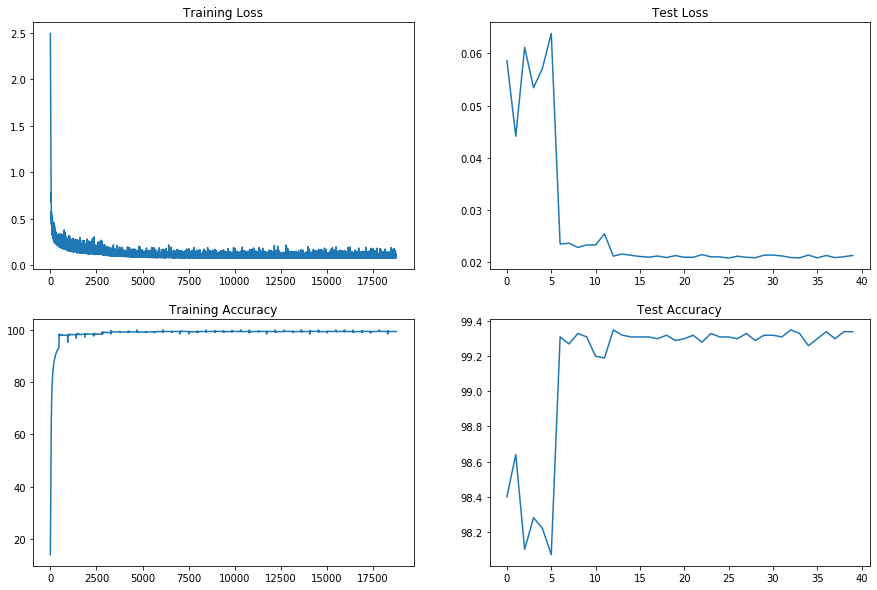

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
for (i, [data, target]) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (pred !=  target).view(-1)
    img_nm = data[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
        correct_label_list.extend(target[idxs_mask].cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


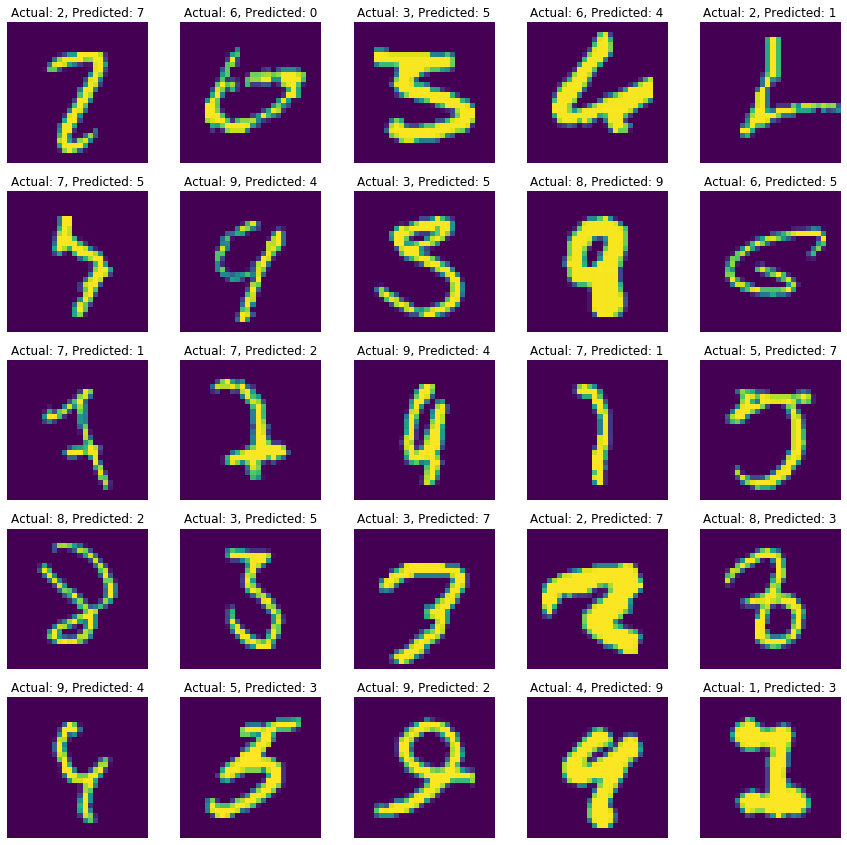

In [0]:
plt.figure(figsize=(15,15))
columns = 5
i= 0
# Display the list of 25 misclassified images
for index, image in enumerate(incorrect_image_list) :
    ax = plt.subplot(5, 5, i+1)
    ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
    ax.axis('off')
    plt.imshow(image)
    i +=1
    if i==25:
        break